In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import pymc as pm
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt

In [181]:
def download_and_prepare_data(ticker='TSLA', start_date='2020-01-01', end_date=None, window=20):
    df = yf.download(ticker, start=start_date, end=end_date)
    df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['daily_vol'] = df['log_return'].rolling(window=window).std()
    df['daily_variance'] = df['daily_vol']**2
    df['anaulized_vol'] = df['daily_vol'] * np.sqrt(252)
    df = df.dropna()
    return df

# Heston model
$$
d \nu(t) = \kappa(\theta - \nu(t) ) dt + \xi \sqrt{\nu(t)} dW_{t}^\nu
$$
where 
1) $\nu(t)$ is the volatility
2) $\kappa$ is the mean reversion rate
3) $\theta$ is the long-term variance
4) $\xi$ is the volatility of volatility
5) $W_t^\nu$ is a Wiener process

The paramters follows the Feller condition:
$2\kappa \theta > \xi^2$

In [185]:
df = download_and_prepare_data('TSLA', '2020-01-01')

[*********************100%***********************]  1 of 1 completed


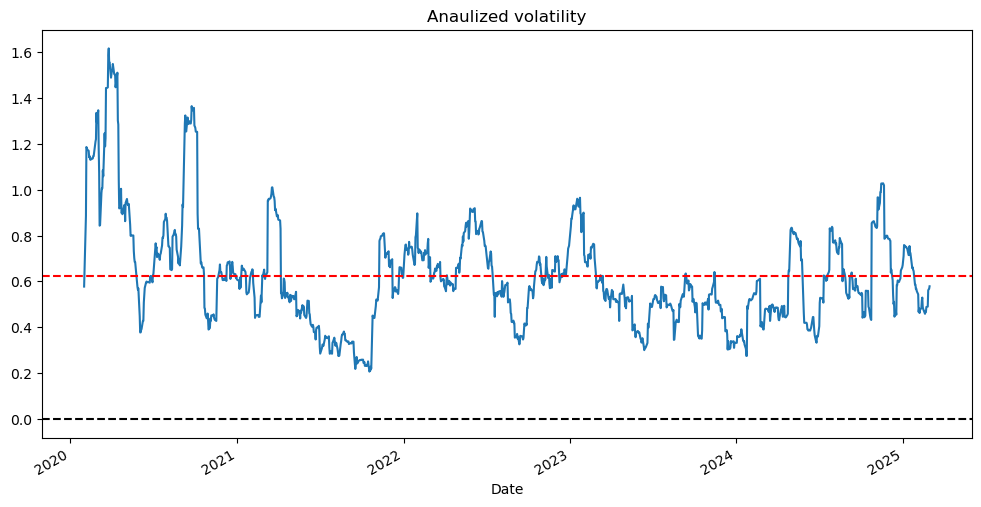

In [187]:
plt.figure(figsize = (12,6))
df['anaulized_vol'].plot(title='Anaulized volatility')
plt.axhline(y=df['anaulized_vol'].mean(),linestyle='--',color='red',label='mean')
plt.axhline(y=0,linestyle='--',color='black')
plt.show()

# Method
We will use Bayesian method to fit all these parameters. We can just the estimated parameter $\hat{\Theta} =\{\hat{\kappa}, \hat{\theta}, \hat{\xi}\}$ for the prior. 

1) $\hat{\theta}$ = mean of log-return
2) $\hat{\xi}$ = variance of volatility
3) $\hat{\kappa}$ = -ln(Corr($\nu_t,\nu_{t-1}$))/$\Delta t$, where $\Delta t$ = 1 Day(depends on your data)

In [190]:
def estimate_initial_parameters(variance_series):
    try:
        theta_est = variance_series.mean()
        xi_est = variance_series.std() / np.sqrt(max(variance_series.mean(), 1e-10))
        autocorr = max(0.01, min(variance_series.autocorr(lag=1), 0.99))
        dt = 1/252
        kappa_est = -np.log(autocorr) / dt
        kappa_est = max(0.1, min(kappa_est, 50))
        
        v0_est = variance_series.iloc[0]
        
        return {
            'kappa': kappa_est,
            'theta': theta_est,
            'xi': xi_est,
            'v0': v0_est
        }
    except Exception as e:
        print(f"Error estimating parameters: {e}")
        # Return default values if estimation fails
        return {
            'kappa': 2.0,
            'theta': 0.04,
            'xi': 0.3,
            'v0': 0.04
        }

Let's do a simple simulation using these estimated parameters first before the fitting.

The evolution is
$$
\nu(t+\Delta t) = \nu(t) + d \nu(t)
$$

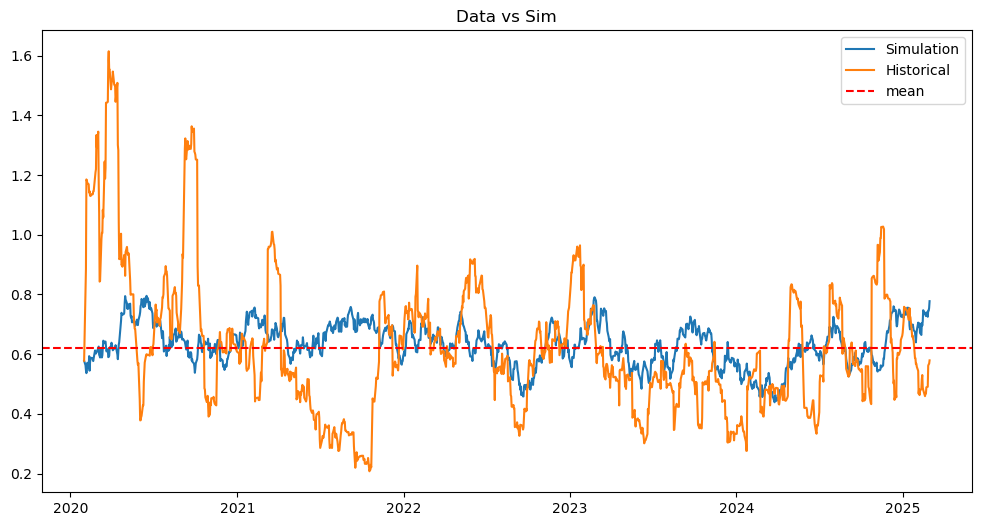

In [193]:
def Simple_Heston(df,dt=1/252, plot=False):
    time_steps = len(df)
    param_estimates = estimate_initial_parameters(df['daily_variance'])
    theta = param_estimates['theta']
    kappa = param_estimates['kappa']
    xi = param_estimates['xi']
    v0 = param_estimates['v0']
    
    # Standard normal innovations
    Z = np.random.normal(0, 1, time_steps)
    
    v = np.zeros(time_steps)
    v[0] = v0
    
    for i in range(1,time_steps):
        # Euler-Maruyama discretization
        drift = kappa * (theta - v[i-1]) * dt
        diffusion = xi * np.sqrt(np.maximum(v[i-1], 1e-6)) * np.sqrt(dt) * Z[i]
        v_next = v[i-1] + drift + diffusion
        v_next = np.maximum(v_next, 1e-10)
        v[i] = v_next
    
    if plot:
        plt.figure(figsize=(12,6))
        plt.plot(df.index, v**(1/2)*np.sqrt(252), label='Simulation')
        plt.plot(df.index, df['anaulized_vol'], label='Historical')
        plt.axhline(y=df['anaulized_vol'].mean(),linestyle='--',color='red',label='mean')
        plt.legend()
        plt.title('Data vs Sim')
        plt.show()
    return v

v_sim = Simple_Heston(df,plot=True)

In [195]:
def create_heston_model(observed_variance, dt=1/252, param_estimates=None):
    time_steps = len(observed_variance)
    
    if param_estimates is None:
        param_estimates = {
            'kappa': 2.0,
            'theta': observed_variance.mean(),
            'xi': 0.3,
            'v0': observed_variance[0]
        }
    
    with pm.Model() as model:
        # Priors based on data estimates
        kappa = pm.Gamma("kappa", alpha=2, beta=1/param_estimates['kappa'], 
                         initval=param_estimates['kappa'])
        
        theta = pm.Gamma("theta", alpha=2, beta=1/param_estimates['theta'], 
                        initval=param_estimates['theta'])
        
        xi = pm.HalfNormal("xi", sigma=param_estimates['xi']*2, 
                          initval=param_estimates['xi'])
        
        v0 = pm.HalfNormal("v0", sigma=param_estimates['v0']*2, 
                          initval=param_estimates['v0'])
        
        # Standard normal innovations
        Z = pm.Normal("Z", mu=0, sigma=1, shape=time_steps-1)
        
        v = pt.zeros(time_steps)
        v = pt.set_subtensor(v[0], v0)
        
        def step(i, v_prev, kappa, theta, xi, Z):
            # Euler-Maruyama discretization
            drift = kappa * (theta - v_prev) * dt
            diffusion = xi * pt.sqrt(pt.maximum(v_prev, 1e-6)) * pt.sqrt(dt) * Z[i]
            v_next = v_prev + drift + diffusion
            v_next = pt.maximum(v_next, 1e-10)
            return v_next
        
        results, _ = pytensor.scan(
            fn=step,
            sequences=pt.arange(time_steps-1),
            outputs_info=v0,
            non_sequences=[kappa, theta, xi, Z]
        )
        
        v = pt.set_subtensor(v[1:], results)
        
        sigma_obs = pm.HalfNormal("sigma_obs", sigma=0.005)
        observed = pm.Normal("observed", mu=v, sigma=sigma_obs, observed=observed_variance)
    
    return model

In [197]:
def run_heston_estimation(df, samples=1000, tune=1000, chains=2):

    observed_variance = df['daily_variance'].values
    param_estimates = estimate_initial_parameters(df['daily_variance'])
    print("Initial parameter estimates:")
    for param, value in param_estimates.items():
        print(f"  {param}: {value:.6f}")
    
    # PyMC model
    model = create_heston_model(observed_variance, param_estimates=param_estimates)
    
    # Sample from the posterior
    with model:
        try:
            idata = pm.sample(samples, tune=tune, chains=chains, target_accept=0.9)
            summary = pm.summary(idata)
        except Exception as e:
            print(f"NUTS sampling failed: {e}")
            print("Trying Metropolis sampler instead...")
            idata = pm.sample(samples, tune=tune, chains=chains, step=pm.Metropolis())
            summary = pm.summary(idata)
    
    return {
        'data': df,
        'model': model,
        'idata': idata,
        'summary': summary,
        'param_estimates': param_estimates,
        'observed_variance': observed_variance
    }

In [199]:
results = run_heston_estimation(df)

Initial parameter estimates:
  kappa: 5.529137
  theta: 0.001748
  xi: 0.035243
  v0: 0.001325


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kappa, theta, xi, v0, Z, sigma_obs]


Output()

NUTS sampling failed: Not enough samples to build a trace.
Trying Metropolis sampler instead...


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [kappa]
>Metropolis: [theta]
>Metropolis: [xi]
>Metropolis: [v0]
>Metropolis: [Z]
>Metropolis: [sigma_obs]

KeyboardInterrupt



In [ ]:
def plot_results(results):
    df = results['data']
    idata = results['idata']

    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    # Closing price
    axes[0].plot(df.index, df['Close'])
    axes[0].set_title('Closing Price')
    axes[0].set_ylabel('Price')
    
    # Historical volatility
    axes[1].plot(df.index, df['anaulized_vol'] * 100, label='Historical Volatility')
    axes[1].set_title('Volatility (Annualized, %)')
    axes[1].set_ylabel('Volatility %')
    axes[1].legend()
    
    # Parameter estimates from idata
    posterior = idata.posterior
    kappa_mean = float(posterior.kappa.mean())
    theta_mean = float(posterior.theta.mean())
    xi_mean = float(posterior.xi.mean())
    v0_mean = float(posterior.v0.mean())
    
    # Simulate fitted variance path with posterior means
    dt = 1/252
    steps = len(results['observed_variance'])
    fitted_variance = np.zeros(steps)
    fitted_variance[0] = v0_mean
    
    # Generate random noise for simulation
    np.random.seed(42)
    Z = np.random.normal(0, 1, steps-1)
    
    # Simulate the path
    for t in range(1, steps):
        drift = kappa_mean * (theta_mean - fitted_variance[t-1]) * dt
        diffusion = xi_mean * np.sqrt(max(fitted_variance[t-1], 1e-6)) * np.sqrt(dt) * Z[t-1]
        fitted_variance[t] = fitted_variance[t-1] + drift + diffusion
        fitted_variance[t] = max(fitted_variance[t], 1e-10)
    
    # Convert to annualized volatility percentage
    fitted_vol = np.sqrt(fitted_variance) * np.sqrt(252) * 100
    observed_vol = np.sqrt(results['observed_variance']) * np.sqrt(252) * 100
    
    # Plot observed vs fitted volatility
    axes[2].plot(df.index, observed_vol, 'b-', label='Observed Volatility')
    axes[2].plot(df.index, fitted_vol, 'r--', label='Fitted Heston Model')
    axes[2].set_title('Observed vs. Fitted Volatility (%)')
    axes[2].set_ylabel('Volatility %')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot the posterior distributions
    with results['model']:
        az.plot_trace(idata)
        plt.tight_layout()
        plt.show()
    
    # Print the posterior summary
    print("\nPosterior Parameter Estimates:")
    print(results['summary'])
    
    # Calculate annualized values for easier interpretation
    print("\nAnnualized Interpretation:")
    print(f"Long-run volatility (√θ): {np.sqrt(theta_mean) * np.sqrt(252) * 100:.2f}%")
    print(f"Mean reversion speed (κ): {kappa_mean:.4f} (half-life: {np.log(2)/kappa_mean:.2f} years)")
    print(f"Volatility of volatility (ξ): {xi_mean:.4f}")

In [ ]:
plot_results(results)